In [7]:
# pip instal _
#  pandas>=1.5.0
# mysql-connector-python>=8.0.0
# numpy>=1.21.0
# python-dotenv>=0.19.0 

In [8]:
# import sys
# import os
# sys.path.append(os.getcwd())
from mysql_data_explorer import get_all_tables_from_mysql

all_tabels = get_all_tables_from_mysql()
print(all_tabels.keys())

✅ Connected to Azure MySQL database: mysql_dpu
📊 Found 5 tables: ['actions', 'feedback_actions', 'player', 'tutorial_actions', 'user_choices']


c:\Users\matan\master_thesis\minigrid_custom\mysql_data_explorer.py:82: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection)
c:\Users\matan\master_thesis\minigrid_custom\mysql_data_explorer.py:82: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, self.connection)


   ✅ Loaded 'actions': 0 rows, 11 columns
   ✅ Loaded 'feedback_actions': 115 rows, 10 columns
   ✅ Loaded 'player': 1 rows, 2 columns
   ✅ Loaded 'tutorial_actions': 143 rows, 8 columns
   ✅ Loaded 'user_choices': 43 rows, 10 columns
🔌 Database connection closed
dict_keys(['actions', 'feedback_actions', 'player', 'tutorial_actions', 'user_choices'])


In [9]:
feedback_actions = all_tabels['feedback_actions']
feedback_actions.head()

,id,user_id,env_state,agent_action,feedback_action,feedback_explanation,action_index,timestamp,episode_index,agent_path
0,1,71,"[[[2, 5, 0], [2, 5, 0], [2, 5, 0], [2, 5, 0], ...",Actions.pickup,Actions.right,,9,2025-07-09 09:56:34,1,"models/3,3,3,0.1,0.1Steps100Grid8_20250602/bes..."
1,2,71,"[[[2, 5, 0], [2, 5, 0], [2, 5, 0], [2, 5, 0], ...",Actions.forward,Actions.right,,1,2025-07-09 09:57:33,2,"models/-1,-1,4,0.2,0.1Steps70Grid8_20250625/be..."
2,3,71,"[[[2, 5, 0], [2, 5, 0], [2, 5, 0], [2, 5, 0], ...",Actions.left,Actions.forward,,14,2025-07-09 09:57:33,2,"models/-1,-1,4,0.2,0.1Steps70Grid8_20250625/be..."
3,4,71,"[[[2, 5, 0], [2, 5, 0], [2, 5, 0], [2, 5, 0], ...",Actions.right,Actions.forward,,2,2025-07-09 09:58:17,3,"models/-1,4,-1,0.2,0.1Steps60Grid8_20250618/be..."
4,5,71,"[[[2, 5, 0], [2, 5, 0], [8, 1, 0], [1, 0, 0], ...",Actions.forward,Actions.right,,4,2025-07-09 09:58:18,3,"models/-1,4,-1,0.2,0.1Steps60Grid8_20250618/be..."


In [10]:
user_choises = all_tabels['user_choices']
user_choises.head()

,id,user_id,old_agent_path,new_agent_path,timestamp,demonstration_time,episode_index,choice_to_update,choice_explanation,simillarity_level
0,1,70,"models/3,3,3,0.1,0.1Steps100Grid8_20250602/bes...","models/2,2,4,-4,0.1Steps50Grid8_20250617/best_...",2025-07-09 09:59:41,2025-07-09T06:59:34.781Z,1,0,,1
1,2,70,"models/2,2,4,-4,0.1Steps50Grid8_20250617/best_...","models/-0.5,3,4,0.2,0.1Steps50Grid8_20250616/b...",2025-07-09 10:00:21,2025-07-09T07:00:13.742Z,2,0,,1
2,3,70,"models/-0.5,3,4,0.2,0.1Steps50Grid8_20250616/b...","models/-1,3,4,-3,0.1Steps60Grid8_20250618/best...",2025-07-09 10:00:51,2025-07-09T07:00:43.501Z,3,0,,1
3,4,67,"models/3,3,3,0.1,0.1Steps100Grid8_20250602/bes...","models/2,2,4,-4,0.1Steps50Grid8_20250617/best_...",2025-07-09 10:03:15,2025-07-09T07:02:56.754Z,1,0,,2
4,5,67,"models/2,2,4,-4,0.1Steps50Grid8_20250617/best_...","models/-0.5,3,4,-3,0.1Steps50Grid8_20250616/be...",2025-07-09 10:04:13,2025-07-09T07:04:00.433Z,2,1,,2


In [11]:
import pandas as pd
def calculate_choice_times(user_choices_df, feedback_actions_df):
    """
    Calculate time difference between feedback and choices
    """
    print("⏱️ Calculating choice times...")
    
    # Convert timestamps to datetime
    user_choices_df['choice_time'] = pd.to_datetime(user_choices_df['timestamp'])
    feedback_actions_df['feedback_time'] = pd.to_datetime(feedback_actions_df['timestamp'])
    
    # Initialize time differences list
    time_diffs = []
    
    for idx, choice in user_choices_df.iterrows():
        user_id = choice['user_id']
        choice_time = choice['choice_time']
        old_agent_path = choice['old_agent_path']
        
        # Find relevant feedback actions
        relevant_feedback = feedback_actions_df[
            (feedback_actions_df['user_id'] == user_id) &
            (feedback_actions_df['agent_path'] == old_agent_path) &
            (feedback_actions_df['feedback_time'] < choice_time) &
            (feedback_actions_df['feedback_time'] > (choice_time - pd.Timedelta(minutes=5)))
        ]
        
        if len(relevant_feedback) > 0:
            # Get the latest feedback before the choice
            latest_feedback = relevant_feedback.loc[relevant_feedback['feedback_time'].idxmax()]
            feedback_time = latest_feedback['feedback_time']
            
            # Calculate time difference in seconds
            time_diff = (choice_time - feedback_time).total_seconds()
            time_diffs.append(time_diff)
            
            print(f"User {user_id}: {time_diff:.1f}s between feedback and choice")
        else:
            time_diffs.append(None)
            print(f"User {user_id}: No relevant feedback found")
    
    # Add time differences to the dataframe
    user_choices_df['time_since_feedback'] = time_diffs
    
    return user_choices_df

# Run the analysis
user_choices_with_times = calculate_choice_times(user_choises, feedback_actions)

# Show results
print(f"\n📊 Time analysis results:")
print(user_choices_with_times[['user_id', 'choice_to_update', 'simillarity_level', 'time_since_feedback']].head(10))

# Summary by similarity level
print(f"\n⏱️ Average time by similarity level:")
for level in range(5):
    level_data = user_choices_with_times[user_choices_with_times['simillarity_level'] == level]
    if len(level_data) > 0:
        avg_time = level_data['time_since_feedback'].mean()
        print(f"Level {level}: {avg_time:.1f}s average")

⏱️ Calculating choice times...
User 70: 8.0s between feedback and choice
User 70: 9.0s between feedback and choice
User 70: 9.0s between feedback and choice
User 67: 20.0s between feedback and choice
User 67: 14.0s between feedback and choice
User 67: 10.0s between feedback and choice
User 67: 37.0s between feedback and choice
User 96: 7.0s between feedback and choice
User 96: 25.0s between feedback and choice
User 96: 9.0s between feedback and choice
User 96: 7.0s between feedback and choice
User 7: 7.0s between feedback and choice
User 7: 47.0s between feedback and choice
User 7: 11.0s between feedback and choice
User 7: 10.0s between feedback and choice
User 100: 13.0s between feedback and choice
User 100: 8.0s between feedback and choice
User 100: 16.0s between feedback and choice
User 100: 8.0s between feedback and choice
User 100: 15.0s between feedback and choice
User 101: 26.0s between feedback and choice
User 101: 14.0s between feedback and choice
User 101: 10.0s between feedb

🔍 Analyzing user choices...
📊 Clean data shape: (42, 16)

📈 Results by similarity level:
��️ Level 0: No data
🎚️ Level 1: 1/3 correct (33.0%)
🎚️ Level 2: 3/4 correct (75.0%)
🎚️ Level 3: 3/7 correct (43.0%)
🎚️ Level 4: 11/28 correct (39.0%)

🎯 Final Result: [0, 0.33, 0.75, 0.43, 0.39]


C:\Users\matan\AppData\Local\Temp\ipykernel_36112\2395785899.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['correct_decision'] = (


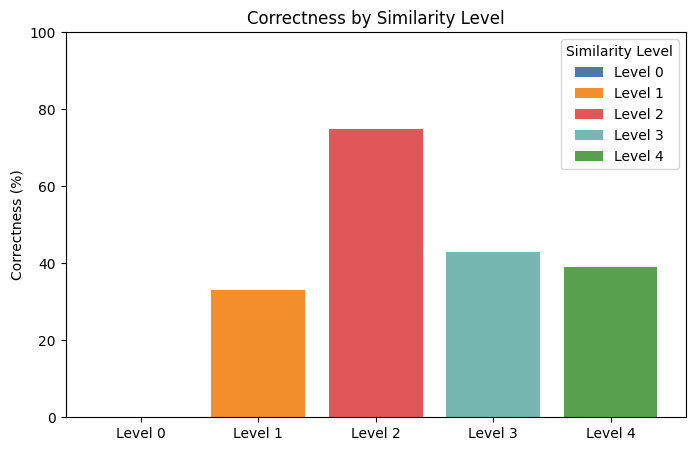

In [12]:
models_eval = {'3,3,3,0.1,0.1Steps100Grid8_20250602': -3.584860000000017, 
 '3,3,4,0.2,0.05Steps50Grid8_20250604': -16.003919999999667, 
 '2,2,4,-4,0.1Steps50Grid8_20250617': 3.3411399999999576, 
 '-1,-1,4,0.2,0.1Steps70Grid8_20250625': -3.6720200000000305, 
 '-0.5,2,4,-3,0.1Steps50Grid8_20250612_good': 4.5956399999999, 
 '-0.5,3,4,0.2,0.1Steps50Grid8_20250616': 0.7418600000000011, 
 '-1,4,-1,0.2,0.1Steps60Grid8_20250618': -3.6132600000000124, 
 '-1,3,4,-3,0.1Steps60Grid8_20250618': 2.717980000000023, 
 '-0.5,3,4,-3,0.1Steps50Grid8_20250616': 4.7921799999998855,
  '-1,3,4,0.2,0.2Steps50Grid8_20250617': 0.7431600000000003}


def calculate_correct_answers_by_similarity_level(user_choices_df, models_eval_dict):
    """
    Calculate correct answers for each similarity level (0-4)
    """
    print("🔍 Analyzing user choices...")
    
    # Extract model names from agent paths
    def extract_model_name(path):
        if pd.isna(path):
            return None
        if 'models/' in str(path):
            parts = str(path).split('/')
            if len(parts) >= 2:
                return parts[1]  # Get model folder name
        return str(path)
    
    # Create new columns with extracted model names
    user_choices_df = user_choices_df.copy()
    user_choices_df['old_model_name'] = user_choices_df['old_agent_path'].apply(extract_model_name)
    user_choices_df['new_model_name'] = user_choices_df['new_agent_path'].apply(extract_model_name)
    
    # Get values for old and new models
    user_choices_df['old_value'] = user_choices_df['old_model_name'].map(models_eval_dict)
    user_choices_df['new_value'] = user_choices_df['new_model_name'].map(models_eval_dict)
    
    # Remove rows with missing values
    final_df = user_choices_df.dropna(subset=['old_value', 'new_value'])
    print(f"📊 Clean data shape: {final_df.shape}")
    
    # Calculate correct decisions
    final_df['correct_decision'] = (
        ((final_df['choice_to_update'] == 1) & (final_df['new_value'] >= final_df['old_value'])) |
        ((final_df['choice_to_update'] == 0) & (final_df['new_value'] <= final_df['old_value']))
    )
    
    # Calculate correct answers for each similarity level
    correct_answers_by_level = []
    
    print("\n📈 Results by similarity level:")
    for level in range(5):
        level_data = final_df[final_df['simillarity_level'] == level]
        
        if len(level_data) > 0:
            correct_decisions = level_data['correct_decision'].sum()
            total_decisions = len(level_data)
            accuracy = correct_decisions / total_decisions
            accuracy = round(accuracy, 2)
            
            print(f"🎚️ Level {level}: {correct_decisions}/{total_decisions} correct ({accuracy*100:.1f}%)")
            correct_answers_by_level.append(accuracy)
        else:
            print(f"��️ Level {level}: No data")
            correct_answers_by_level.append(0)
    
    return correct_answers_by_level

# Run the analysis
correct_answers = calculate_correct_answers_by_similarity_level(user_choises, models_eval)
print(f"\n🎯 Final Result: {correct_answers}")


import matplotlib.pyplot as plt

groups = ['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4']
colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f']

plt.figure(figsize=(8, 5))
bars = plt.bar(groups, [c * 100 for c in correct_answers], color=colors)

plt.ylabel('Correctness (%)')
plt.title('Correctness by Similarity Level')
plt.ylim(0, 100)
plt.legend(bars, groups, title="Similarity Level")
plt.show()